In [1]:
import numpy as np
import tensorflow as tf
import random
from collections import deque
import dqn
import gym
from typing import List
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')
#env = gym.wrappers.Monitor(env, directory="result/", force = True)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
INPUT_SIZE = env.observation_space.shape[0]
OUTPUT_SIZE = env.action_space.n

DISCOUNT_RATE = 0.9
REPLAY_MEMORY = 50000
BATCH_SIZE = 64
TARGET_UPDATE_FREQUENCY = 5
MAX_EPISODES = 5000

In [4]:
def replay_train(mainDQN:dqn.DQN, targetDQN:dqn.DQN, train_batch:list):
    " train mainDQN with target Q vaues given by targetDQN"
    states = np.vstack([x[0] for x in train_batch])
    actions = np.array([x[1] for x in train_batch])
    rewards = np.array([x[2] for x in train_batch])
    next_states = np.array([x[3] for x in train_batch])
    done = np.array([x[4] for x in train_batch])
    
    X = states
    
    Q_target = rewards + DISCOUNT_RATE * np.max(targetDQN.predict(next_states), axis=1) * ~done
    
    y = mainDQN.predict(states)
    y[np.arange(len(X)), actions] = Q_target
    return mainDQN.update(X, y)    

In [5]:
def get_copy_var_ops(*, dest_scope_name:str, src_scope_name:str):
    op_holder = []
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
    return op_holder


In [6]:
def bot_play(mainDQN: dqn.DQN, env:gym.Env):
    states = env.reset()
    reward_sum = 0
    
    while True:
        env.render()
        action = np.argmax(mainDQN.predict(state))
        state. reward, done, _ = env.step(action)
        reward_sum += reward
        if done:
            print("\n Total score: {}".format(reward_sum))
            break
            


In [7]:
def main():
    replay_buffer = deque(maxlen=REPLAY_MEMORY)
    last_100_game_reward = deque(maxlen=100)
    step_list = []
    
    with tf.Session() as sess:
        mainDQN = dqn.DQN(sess, INPUT_SIZE, OUTPUT_SIZE, name="main")
        targetDQN = dqn.DQN(sess, INPUT_SIZE, OUTPUT_SIZE, name="target")
        sess.run(tf.global_variables_initializer())
        
        copy_ops = get_copy_var_ops(dest_scope_name = "target",
                                   src_scope_name = "main")
        sess.run(copy_ops)
        
        for epi in range(MAX_EPISODES):
            e = 1./((epi/10)+1)
            done = False
            step_count = 0
            state = env.reset()
            
            while not done:
                if np.random.rand() < e:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(mainDQN.predict(state))
                next_state, reward, done, _ = env.step(action)
                
                if done:
                    reward = -1
                    
                replay_buffer.append((state, action, reward, next_state, done))
                
                if len(replay_buffer) > BATCH_SIZE:
                    minibatch = random.sample(replay_buffer, BATCH_SIZE)
                    loss, _ = replay_train(mainDQN, targetDQN, minibatch)
                    
                if step_count % TARGET_UPDATE_FREQUENCY == 0:
                    sess.run(copy_ops)
                    
                state = next_state
                step_count += 1
            
            print("Episode : {} step: {}".format(epi+1, step_count), end = "\r")
            step_list.append(step_count)

            last_100_game_reward.append(step_count)
            
            if len(last_100_game_reward) == last_100_game_reward.maxlen:
                avg_reward = np.mean(last_100_game_reward)
                if avg_reward > 199:
                    print("Game cleared in {} episode with avg reward {}".format(epi+1, avg_reward))
                    step_array = np.asarray(step_list)
                    plt.plot(step_array)
                    break

Game cleared in 259 episode with avg reward 199.34


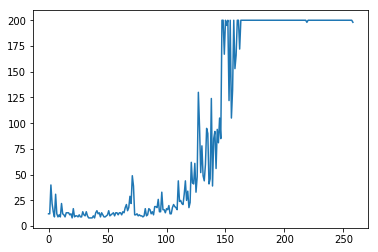

In [8]:
main()